In [8]:
import numpy as np
import heapq

class Embeddings:
    def __init__(self, path):
        self.V = self.normalize(np.load(path + '.npy'))
        self.vocab = open(path + '.vocab').read().strip().split()
        self.w2i = dict([(w, i) for i, w in enumerate(self.vocab)])

    @staticmethod
    def normalize(vecs):
        normalizers = np.sqrt(np.sum(vecs * vecs, axis=1))
        normalizers[normalizers == 0] = 1
        return vecs / normalizers[:, np.newaxis]

    def wvec(self, w):
        """ get vector for word w """
        if w in self.w2i:
            return self.V[self.w2i[w], :]
        else:
            return None
    
    def cos(self, v, w=None):
        if w is None:
            return np.dot(self.V, v)
        else:                
            return np.dot(self.wvec(w), v)

    def pcos(self, v, w=None):
        if w is None:
            return (self.cos(v) + 1) / 2
        else:
            return (self.cos(v, w) + 1) / 2
    
    def top_scores(self, scores, n=10):
        if n <= 0:
            n = len(scores)
        return heapq.nlargest(n, zip(self.vocab, scores), key=lambda x: x[1])
    
    def closest(self, v, n=10):
#         print('v:', type(v))
        scores = self.cos(v)
        
        if n is None:
            n = len(scores)
            
        return heapq.nlargest(n, zip(self.vocab, scores), key=lambda x: x[1])

    @staticmethod
    def pcos_mat(V1, V2):
        return (np.diag(np.dot(V1, V2.T)) + 1) / 2

In [9]:
wemb = Embeddings('/fastdata/cop15rj/results/models/w/1/50/vecs')
cemb = Embeddings('/fastdata/cop15rj/results/models/w/1/50/contexts')

In [ ]:
contexts = cemb.closest(wemb.wvec('apple'), None)

rels = set()
for context in contexts:
    if 'fruit' in context[0]:
#         print('1', context)
        rels.add(context[0].split('_')[0])
    if 'company' in context[0]:
#         print('2', context)
        rels.add(context[0].split('_')[0])
    
print(rels)
print(contexts)

In [71]:
cemb.closest(cemb.wvec('amodI_company'))

[('amodI_company', 0.99999999999999933),
 ('amodI_companies', 0.83271854367315123),
 ('amodI_firm', 0.81314601647327578),
 ('amodI_corporation', 0.78451170396271008),
 ('amodI_manufacturer', 0.77748370590083649),
 ('amodI_retailer', 0.76840621957541122),
 ('amodI_provider', 0.76694246705783509),
 ('amodI_organisation', 0.76640209190246888),
 ('amodI_agency', 0.75348888053083152),
 ('amodI_industry', 0.75161080384322099)]

In [225]:
wemb.closest(cemb.wvec('dobj_banana'))

[('borrows', 0.94989252564961246),
 ('reserving', 0.94949155875329683),
 ('surpassing', 0.94739372255254217),
 ('seizes', 0.94444144132014984),
 ('ditching', 0.94424863966418637),
 ('embodying', 0.94418858085974366),
 ('straddling', 0.94390985305761077),
 ('shatters', 0.941675475330364),
 ('brandishing', 0.94164060415154238),
 ('clutching', 0.9412669935709953)]

In [127]:
# wemb.closest(wemb.wvec('apple') + cemb.wvec('dobj_company'), 20)
wemb.closest(cemb.wvec('amod_strong'), 20)

[('winds', 0.12714918838362921),
 ('reputation', 0.11749581997919625),
 ('opposition', 0.10226918195736882),
 ('ties', 0.094144591305693442),
 ('relationships', 0.086262275010461936),
 ('commitment', 0.084171616841909852),
 ('accent', 0.083019627331848478),
 ('presence', 0.079072233893631647),
 ('leadership', 0.077679940716463627),
 ('resemblance', 0.077615321785289376),
 ('argument', 0.074340423734557029),
 ('affinity', 0.073509433814468256),
 ('relationship', 0.070228093864681512),
 ('aroma', 0.069887116531079041),
 ('flair', 0.069007607442021834),
 ('tendency', 0.066949934093481892),
 ('flavour', 0.066858208676293052),
 ('correlation', 0.065217500779744031),
 ('bond', 0.06294155987580681),
 ('links', 0.062916633230173005)]

In [71]:
search_word = 'compound_system'
for context in cemb.vocab:
    if search_word in context:
        print(context)

compound_system
compound_systems


In [ ]:
from sklearn.manifold import TSNE
from collections import Counter

words = ['buy', 'acquire', 'learn', 'purchase']

iw = []
ic = []
for word in words:
    iw.append(wemb.w2i[word])
    contexts = cemb.closest(wemb.wvec(word), 1000)
    
    for context in contexts:
        ic.append(context[0])
    
# print(iw)
# print('ic :',ic)
counter = Counter(ic)
ic = [c for c in counter if counter[c] > 1]

print('ic :',ic)

wvecs = wemb.V[iw,:]
# cvecs = cemb.V[ic,:]

# print(wvecs.shape)

tsne = TSNE(n_components=2, random_state=0)
pc = tsne.fit_transform(wvecs) * 1e+2

print(pc)

In [267]:
from sklearn.manifold import TSNE
from collections import Counter

words = ['learn', 'acquire', 'buy', 'purchase']
contexts = ['dobj_stock', 'dobj_company', 'dobj_skill', 'dobj_car', 'dobj_habit', 'dobj_language']

iw = []
for word in words:
    iw.append(wemb.w2i[word])
ic = []
for context in contexts:
    ic.append(cemb.w2i[context])
    
wvecs = wemb.V[iw,:]
cvecs = cemb.V[ic,:]

print(wvecs.shape, cvecs.shape)
    
tsne = TSNE(n_components=2)
dw = tsne.fit(wvecs)*1e+4
# dw = dw / np.diag(np.dot(dw, dw.T)).reshape(dw.shape[0], 1) * np.ones((1, 2))

dc = tsne.fit(cvecs)*1e+4
# dc = dc / np.diag(np.dot(dc, dc.T)).reshape(dc.shape[0], 1) * np.ones((1, 2))

(4, 600) (6, 600)


TypeError: unsupported operand type(s) for *: 'TSNE' and 'float'

(-2.5, 2.5)

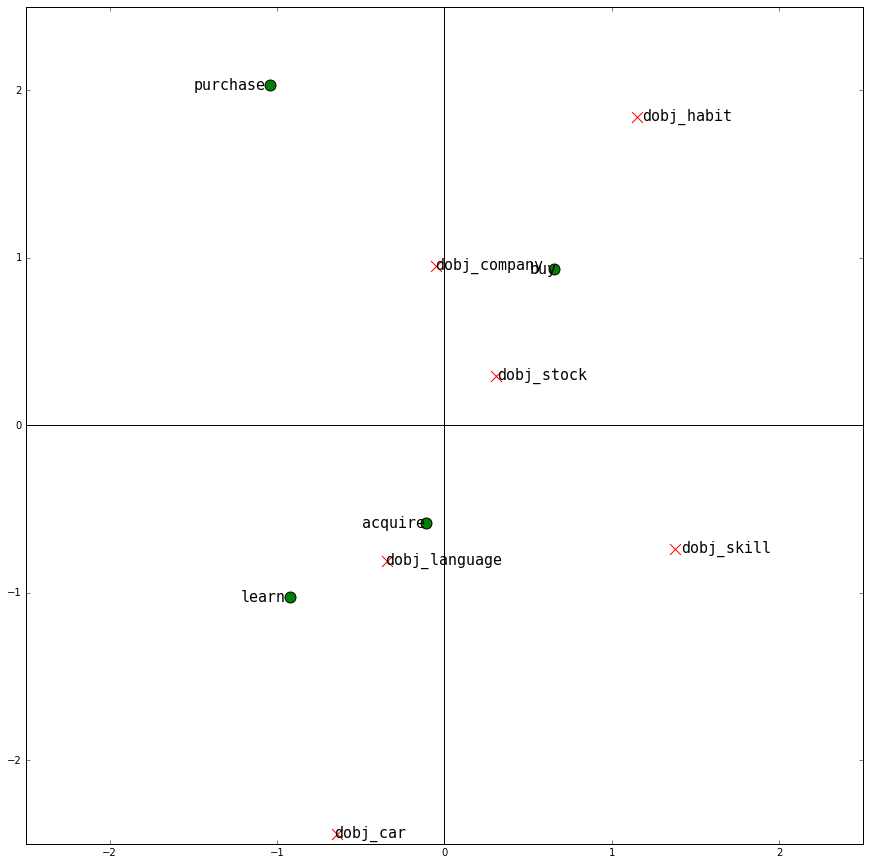

In [268]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(15,15))

for i, key in enumerate(words):
    plt.scatter(dw[i,0], dw[i,1], s=120, c='green', marker='o')
    plt.annotate(key, (dw[i,0]*1.025, dw[i,1]), fontsize=15, 
                 verticalalignment='center', horizontalalignment='right', family='monospace')

for i, key in enumerate(contexts):
    plt.scatter(dc[i,0], dc[i,1], s=120, c='red', marker='x')
    plt.annotate(key, (dc[i,0]*1.025, dc[i,1]), fontsize=15, 
                 verticalalignment='center', horizontalalignment='left', family='monospace')

plt.axhline(0, color='k')
plt.axvline(0, color='k')
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])

In [64]:
from pprint import pprint

contexts = cemb.closest(wemb.wvec('windows'), 20)
pprint(contexts)

[('amod_double-glazed', 0.80908330382790938),
 ('conj_98', 0.69156656286460971),
 ('amod_beaded', 0.66193754412508843),
 ('conjI_desktops', 0.63889427555097145),
 ('conj_projector', 0.63462877900687864),
 ('conjI_fridge/freezer', 0.6289999698710611),
 ('compound_dropdown', 0.62864324654756132),
 ('amod_windows-based', 0.62360057193406826),
 ('conj_fireplaces', 0.61800112811356778),
 ('compoundI_prompt', 0.61648760753592702),
 ('amod_wide-angle', 0.61247845076746787),
 ('compoundI_codecs', 0.6115204467459161),
 ('conj_asp', 0.61110167963090545),
 ('conjI_scanners', 0.61065172539254453),
 ('nmodI_sticker', 0.61001924502867633),
 ('compound_beowulf', 0.60943950605057728),
 ('conj_televisions', 0.60849211971198802),
 ('appos_walls', 0.6071443033078423),
 ('compoundI_decoder', 0.60704360082952658),
 ('amod_replaceable', 0.60253894033451316)]


In [35]:
from tabulate import tabulate

target = 'apple'
contexts = ['nsubjI_company', 'dobjI_eat']

table = []

for context in contexts:
    top_substitutes = wemb.top_scores(wemb.pcos(wemb.wvec(target)) * wemb.pcos(cemb.wvec(context)))    
    column = [x[0] for x in top_substitutes if x[0] != target]
    
    if len(table) > 1:
        table = [x for x in zip(table, column)]
    else:
        table = column

print(tabulate(table, headers=contexts, tablefmt='latex'))

\begin{tabular}{ll}
\hline
 nsubjI\_company   & dobjI\_eat   \\
\hline
 sony             & cheese      \\
 aol              & salad       \\
 microsoft        & pasta       \\
 ibm              & chocolate   \\
 intel            & chicken     \\
 google           & fruit       \\
 bt               & pizza       \\
 coddan           & soup        \\
 corel            & meat        \\
\hline
\end{tabular}


In [37]:
from tabulate import tabulate

target = 'employ'
contexts = ['dobj_technique', 'dobj_specialist']

table = []

for context in contexts:
    top_substitutes = wemb.top_scores(wemb.pcos(wemb.wvec(target)) * wemb.pcos(cemb.wvec(context)))    
    column = [x[0] for x in top_substitutes if x[0] != target]
    
    if len(table) > 1:
        table = [x for x in zip(table, column)]
    else:
        table = column

print(tabulate(table, headers=contexts, tablefmt='latex'))

\begin{tabular}{ll}
\hline
 dobj\_technique   & dobj\_specialist   \\
\hline
 utilise          & consult           \\
 develop          & employing         \\
 devise           & appoint           \\
 adopt            & nominate          \\
 evaluate         & seeking           \\
 using            & instruct          \\
 exploit          & contacting        \\
 deploy           & requesting        \\
 implement        & recruit           \\
\hline
\end{tabular}


In [62]:
from tabulate import tabulate

target = 'train'
contexts = ['dobjI_board', 'dobj_people']

table = []

for context in contexts:
    top_substitutes = wemb.top_scores(wemb.pcos(wemb.wvec(target)) * wemb.pcos(cemb.wvec(context)))    
    column = [x[0] for x in top_substitutes if x[0] != target]
    
    if len(table) > 1:
        table = [x for x in zip(table, column)]
    else:
        table = column

print(tabulate(table, headers=contexts, tablefmt='latex'))

\begin{tabular}{ll}
\hline
 dobjI\_board   & dobj\_people   \\
\hline
 bus           & recruit       \\
 ferry         & greet         \\
 trains        & impress       \\
 boat          & motivate      \\
 taxi          & entice        \\
 coach         & entertain     \\
 ship          & employ        \\
 flight        & educate       \\
 buses         & tempt         \\
\hline
\end{tabular}


In [78]:
from tabulate import tabulate

target = 'windows'
contexts = ['compound_desktop', 'nmod_view']

table = []

for context in contexts:
    top_substitutes = wemb.top_scores(wemb.pcos(wemb.wvec(target)) * wemb.pcos(cemb.wvec(context)))    
    column = [x[0] for x in top_substitutes if x[0] != target]
    
    if len(table) > 1:
        table = [x for x in zip(table, column)]
    else:
        table = column

print(tabulate(table, headers=contexts, tablefmt='latex'))

\begin{tabular}{ll}
\hline
 compound\_desktop   & nmod\_view   \\
\hline
 xp                 & window      \\
 desktop            & bedroom     \\
 linux              & point       \\
 unix               & doors       \\
 server             & balcony     \\
 pcs                & points      \\
 pc                 & door        \\
 servers            & image       \\
 explorer           & lounge      \\
\hline
\end{tabular}
